In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

## data_dir path

In [46]:
from pathlib import Path

In [47]:
data_dir = Path("/content/drive/MyDrive/UIT/projects/CS338_NhanDang/grocery-images")
data_dir

PosixPath('/content/drive/MyDrive/UIT/projects/CS338_NhanDang/grocery-images')

In [48]:
print("train:", len(list((data_dir/"train").glob("*/*.jpg"))))
print("val:", len(list((data_dir/"val").glob("*/*.jpg"))))
print("test:", len(list((data_dir/"test").glob("*/*.jpg"))))

train: 448
val: 128
test: 105


## Configure batch_size, img_shape

In [49]:
batch_size = 32
img_height = 224
img_width = img_height
img_size = (img_height, img_width)
img_shape = img_size + (3, )

## Create train_ds, val_ds, test_ds



In [50]:
import tensorflow as tf

In [51]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir/"train",
    seed=55555,
    image_size=img_size,
    smart_resize=True,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir/"val",
    seed=55555,
    image_size=img_size,
    smart_resize=True,
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir/"test",
    seed=55555,
    image_size=img_size,
    smart_resize=True,
    batch_size=batch_size)

Found 448 files belonging to 64 classes.
Found 128 files belonging to 64 classes.
Found 105 files belonging to 64 classes.


## class_names, num_classes

In [52]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(num_classes, class_names)

64 ['bánh gạo An', 'bánh oreo original', 'bánh quế kem vị cam cosy', 'bình nước khoáng bidrico', 'bình nước khoáng tachiwa', 'bình nước khoáng vĩnh hảo', 'bột canh vifon', 'bột cà ri', 'bột ngũ vị hương', 'bùi nhùi thép', 'bút bi xanh', 'cafe sữa đá (cafe phố - MacCoffee)', 'cafe sữa đá (nescafe 3 in 1)', 'cafe đen đá nescafe', 'chai nước khoáng aquafina 5 lít', 'cháo gói thịt bằm gấu đỏ', 'cháo tổ yến thịt bằm', 'cơm cháy chà bông', 'hủ tiếu nam vang cung đình', 'keo 502', 'keo hai mặt', 'kẹo 4 mùa', 'kẹo DoubleMint', 'kẹo mentos golia', 'kẹo mút con gấu', 'kẹo mút sữa milkita', 'kẹo singum lql hình xăm', 'khẩu trang y tế', 'mắm ruốc trí hải', 'miến vị sườn heo phú hương (gói ăn liền)', 'mirinda soda kem', 'mì chay vị nấm miliket', 'mì giấy (mì tôm)', 'mì gói gấu đỏ', 'mì gói lẩu nấm chua cay reeva', 'mì gói lẩu thái tôm acecook', 'mì gói tô

## Configure the dataset for performance

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Visualize dataset

In [54]:
import matplotlib.pyplot as plt

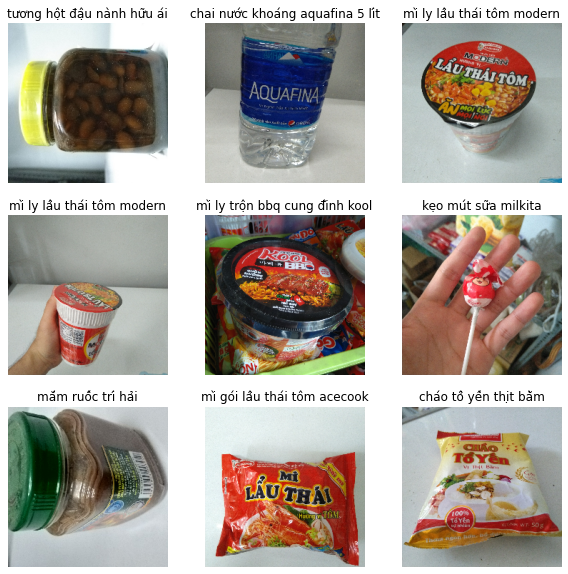

In [55]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# Transfer Learning

## Train models

### Data augmentation layer initialization

In [75]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomRotation, RandomZoom

data_augmentation = Sequential(
    [
     RandomContrast(0.3),
     RandomRotation(0.5),
     RandomZoom((-0.3, 0.3))
    ], 
    name="data_augmentation"
)

### Define the model

In [94]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam


# Instantiate base model
base_model = MobileNetV3Small(input_shape=img_shape, weights="imagenet", include_top=False)

# Define new model
inputs = Input(shape=img_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(192, activation="relu")(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = Model(inputs, outputs)

# Compile the model
base_lr = 5e-4
model.compile(
    optimizer=Adam(learning_rate=base_lr),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

### Train models' heads

In [95]:
initial_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

Epoch 1/10
14/14 [==============================] - 7s 152ms/step - loss: 4.2178 - accuracy: 0.0201 - val_loss: 4.0182 - val_accuracy: 0.0547
Epoch 2/10
14/14 [==============================] - 1s 79ms/step - loss: 3.8131 - accuracy: 0.1295 - val_loss: 3.4760 - val_accuracy: 0.1875
Epoch 3/10
14/14 [==============================] - 1s 78ms/step - loss: 2.9247 - accuracy: 0.3080 - val_loss: 2.2797 - val_accuracy: 0.4453
Epoch 4/10
14/14 [==============================] - 1s 79ms/step - loss: 1.7343 - accuracy: 0.5223 - val_loss: 1.4109 - val_accuracy: 0.6016
Epoch 5/10
14/14 [==============================] - 1s 79ms/step - loss: 1.1204 - accuracy: 0.6652 - val_loss: 1.2050 - val_accuracy: 0.6797
Epoch 6/10
14/14 [==============================] - 1s 78ms/step - loss: 0.7209 - accuracy: 0.8058 - val_loss: 0.9604 - val_accuracy: 0.7656
Epoch 7/10
14/14 [==============================] - 1s 78ms/step - loss: 0.4181 - accuracy: 0.8795 - val_loss: 1.0066 - val_accuracy: 0.7188
Epoch 8/10
1

### Plot validation accuracies

Text(0.5, 0, 'epochs')

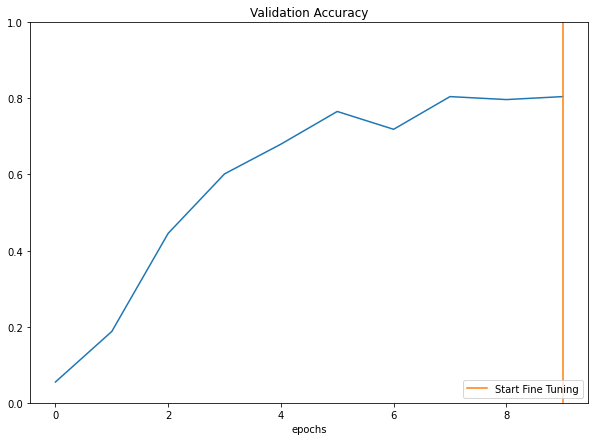

In [96]:
plt.figure(figsize=(10, 7))

val_acc = history.history['val_accuracy']
plt.plot(val_acc)
plt.ylim([0, 1])
    
plt.title('Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('epochs')

## Fine-tuning models

### Unfreeze last 20% layers

In [97]:
# Unfreeze all layers
base_model.trainable = True

In [98]:
# Freeze first 80% layers
nlayers = len(base_model.layers)
freeze_til_here = int(nlayers * 0.75)
for layer in base_model.layers[:freeze_til_here]:
    layer.trainable = False

###  Reduce learning rate

In [99]:
model.compile(
    optimizer=Adam(learning_rate=base_lr/10),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

### Continue training

In [100]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [101]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs


history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks=[stop_early]
)
    

Epoch 10/20
14/14 [==============================] - 5s 101ms/step - loss: 0.1432 - accuracy: 0.9732 - val_loss: 0.5891 - val_accuracy: 0.8594
Epoch 11/20
14/14 [==============================] - 1s 43ms/step - loss: 0.0720 - accuracy: 0.9866 - val_loss: 0.5841 - val_accuracy: 0.8906
Epoch 12/20
14/14 [==============================] - 0s 36ms/step - loss: 0.0683 - accuracy: 0.9821 - val_loss: 0.5647 - val_accuracy: 0.8906
Epoch 13/20
14/14 [==============================] - 1s 37ms/step - loss: 0.0609 - accuracy: 0.9844 - val_loss: 0.5700 - val_accuracy: 0.8750
Epoch 14/20
14/14 [==============================] - 1s 37ms/step - loss: 0.0465 - accuracy: 0.9866 - val_loss: 0.5508 - val_accuracy: 0.8828
Epoch 15/20
14/14 [==============================] - 1s 37ms/step - loss: 0.0415 - accuracy: 0.9955 - val_loss: 0.5632 - val_accuracy: 0.8906
Epoch 16/20
14/14 [==============================] - 1s 37ms/step - loss: 0.0520 - accuracy: 0.9777 - val_loss: 0.5826 - val_accuracy: 0.8750
Epoch

### Plot validation accuracies

Text(0.5, 0, 'epoch')

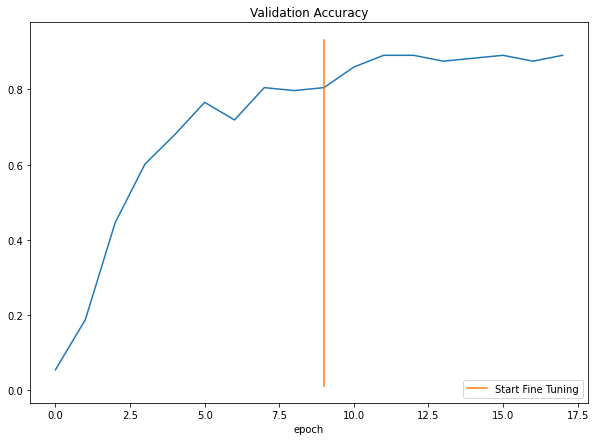

In [102]:
plt.figure(figsize=(10, 7))

val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
plt.plot(val_acc)


plt.title('Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('epoch')

## Save models

In [103]:
saved_model_dir = data_dir.parent/"thinh_imagemodel_SavedModel_6"

In [104]:
model.save(saved_model_dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/UIT/projects/CS338_NhanDang/thinh_imagemodel_SavedModel_6/assets


## Save labels

In [105]:
import json

In [106]:
with open(saved_model_dir/"labels.json", "w", encoding="utf8") as out:
    json.dump(class_names, out, ensure_ascii=False)

# Evaluate models

## Accuracy and size

In [107]:
_, acc = model.evaluate(test_ds)

4/4 [==============================] - 0s 23ms/step - loss: 0.4724 - accuracy: 0.8571


In [108]:
import os

def get_dir_size(root_path):
    total_size = 0
    for path, dirs, files in os.walk(root_path):
        for f in files:
            fp = os.path.join(path, f)
            total_size += os.path.getsize(fp)
    return total_size / 1e6

In [109]:
size = get_dir_size(saved_model_dir)
size

24.483389

## Confused labels

In [110]:
test_image = []
test_labels = []

for image, label in test_ds:
  test_image.append(image.numpy())
  test_labels.append(label.numpy())

test_image = tf.concat(test_image, axis=0)
y_true = tf.concat(test_labels, axis=0)

test_image.shape, y_true.shape

(TensorShape([105, 224, 224, 3]), TensorShape([105]))

In [111]:
def confused_labels(model):
    y_pred = model.predict_on_batch(test_image)
    y_pred = tf.math.argmax(y_pred, axis=1)
    y_pred = tf.cast(y_pred, dtype=tf.int32)

    count_correct = tf.cast(y_pred == y_true, tf.int32)
    count_correct = tf.math.reduce_sum(count_correct)

    test_acc = count_correct / len(y_true)
    print(f'Test set accuracy: {test_acc:.0%}')
    
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    for r, row in enumerate(confusion_mtx):
        for c, val in enumerate(row):
            if r != c and val != 0:
                print(f"[{c}] {class_names[c]} -> [{r}] {class_names[r]}")

In [112]:
confused_labels(model)

Test set accuracy: 86%
[31] mì chay vị nấm miliket -> [2] bánh quế kem vị cam cosy
[28] mắm ruốc trí hải -> [5] bình nước khoáng vĩnh hảo
[0] bánh gạo An -> [10] bút bi xanh
[33] mì gói gấu đỏ -> [15] cháo gói thịt bằm gấu đỏ
[60] túi đựng rác tự phân hủy đệ nhất -> [19] keo 502
[37] mì gói tôm chua cay hảo hảo -> [21] kẹo 4 mùa
[0] bánh gạo An -> [22] kẹo DoubleMint
[57] tỏi -> [24] kẹo mút con gấu
[31] mì chay vị nấm miliket -> [28] mắm ruốc trí hải
[39] mì gói trộn xốt cà chua spaghetti kool -> [35] mì gói lẩu thái tôm acecook
[31] mì chay vị nấm miliket -> [39] mì gói trộn xốt cà chua spaghetti kool
[12] cafe sữa đá (nescafe 3 in 1) -> [48] nước ngọt cocacola
[18] hủ tiếu nam vang cung đình -> [51] phở bò gói  vifon
[8] bột ngũ vị hương -> [54] sữa đặc ngôi sao phương nam
[21] kẹo 4 mùa -> [56] tăm bông ngoáy tai
